In [1]:
import torch
import numpy as np
import matplotlib.pyplot as plt

import trimesh

scene = trimesh.Scene()

In [2]:
import my_code.diffusion_training_sign_corr.data_loading as data_loading

train_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'train', 128, canonicalize_fmap=None, preload=False, return_evecs=True
    )[1]
test_dataset = data_loading.get_val_dataset(
    'FAUST_orig', 'test', 128, canonicalize_fmap=None, preload=False, return_evecs=True
)[1]

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


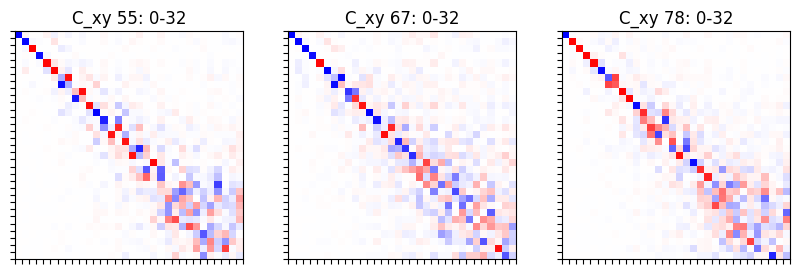

In [3]:
import my_code.utils.plotting_utils as plotting_utils

l = 0
h = 32

fig, axs = plt.subplots(1, 3, figsize=(10, 5))

plotting_utils.plot_Cxy(fig, axs[0], train_dataset[55]['second']['C_gt_xy'][0],
                        'C_xy 55', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], train_dataset[67]['second']['C_gt_xy'][0],
                        'C_xy 67', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[2], train_dataset[78]['second']['C_gt_xy'][0],
                        'C_xy 78', l, h, show_grid=False, show_colorbar=False)



plt.show()

In [8]:
import torch
import numpy as np
import os
from tqdm import tqdm
import yaml

import os

# models
from my_code.models.diag_conditional import DiagConditionedUnet
from diffusers import DDPMScheduler

import my_code.diffusion_training_sign_corr.data_loading as data_loading

from my_code.datasets.surreal_cached_train_dataset import SurrealTrainDataset
import matplotlib.pyplot as plt
import my_code.utils.plotting_utils as plotting_utils
import utils.fmap_util as fmap_util
import metrics.geodist_metric as geodist_metric
from my_code.sign_canonicalization.training import predict_sign_change
import networks.diffusion_network as diffusion_network

In [25]:
import my_code.sign_canonicalization.training as sign_training

def test_time_adaptation(net, train_shape, n_iter):
    
    opt = torch.optim.Adam(net.parameters(), lr=1e-3)
    device = 'cuda'
    loss_fn = torch.nn.MSELoss()
    losses = torch.tensor([])
    
    
    for _ in range(n_iter):
        
        verts = train_shape['verts'].unsqueeze(0).to(device)
        faces = train_shape['faces'].unsqueeze(0).to(device)    

        evecs_orig = train_shape['evecs'].unsqueeze(0)[:, :, :net.in_channels].to(device)
        

        ##############################################
        # Set the signs on shape 0
        ##############################################

        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_0 = torch.randint(0, 2, (net.in_channels,)).float().to(device)
        
        sign_gt_0[sign_gt_0 == 0] = -1
        sign_gt_0 = sign_gt_0.float().unsqueeze(0)

        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_0 = evecs_orig * sign_gt_0
        
        # predict the sign change
        sign_pred_0 = sign_training.predict_sign_change(
            net, verts, faces, evecs_flip_0, 
            mass_mat=None, input_type=net.input_type,
            
            mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
            evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
            gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
            )[0]
        
        ##############################################
        # Set the signs on shape 1
        ##############################################
        
        # create a random combilation of +1 and -1, length = feature_dim
        sign_gt_1 = torch.randint(0, 2, (net.in_channels,)).float().to(device)
        
        sign_gt_1[sign_gt_1 == 0] = -1
        sign_gt_1 = sign_gt_1.float().unsqueeze(0)
        
        # multiply evecs [6890 x 16] by sign_flip [16]
        evecs_flip_1 = evecs_orig * sign_gt_1
        
        # predict the sign change
        sign_pred_1 = sign_training.predict_sign_change(
            net, verts, faces, evecs_flip_1, 
            mass_mat=None, input_type=net.input_type,
            
            mass=train_shape['mass'].unsqueeze(0), L=train_shape['L'].unsqueeze(0),
            evals=train_shape['evals'].unsqueeze(0), evecs=train_shape['evecs'].unsqueeze(0),
            gradX=train_shape['gradX'].unsqueeze(0), gradY=train_shape['gradY'].unsqueeze(0)
            )[0]
        
        ##############################################
        # Calculate the loss
        ##############################################
        
        # calculate the ground truth sign difference
        sign_diff_gt = sign_gt_1 * sign_gt_0
        
        # calculate the sign difference between predicted evecs
        sign_diff_pred = sign_pred_1 * sign_pred_0
        
        # calculate the loss
        loss = loss_fn(
            sign_diff_pred.reshape(sign_diff_pred.shape[0], -1),
            sign_diff_gt.reshape(sign_diff_gt.shape[0], -1)
            )

        opt.zero_grad()
        loss.backward()
        opt.step()
        
        losses = torch.cat([losses, torch.tensor([loss.item()])])
        
    return net, losses
    

In [32]:


experiment_name = 'augShapes_mass_signNet_remeshed_10_0.5_1'
checkpoint_name = 'checkpoint_99.pt'
dataset_name = 'FAUST_r'
split = 'train'

### config
exp_base_folder = f'/home/s94zalek_hpc/shape_matching/my_code/experiments/ddpm/{experiment_name}'
with open(f'{exp_base_folder}/config.yaml', 'r') as f:
    config = yaml.load(f, Loader=yaml.FullLoader)


### model
model = DiagConditionedUnet(config["model_params"]).to('cuda')
model.load_state_dict(torch.load(f"{exp_base_folder}/checkpoints/{checkpoint_name}"))
model = model.to('cuda')

### Sign correction network
sign_corr_net = diffusion_network.DiffusionNet(
    **config["sign_net"]["net_params"]
    ).to('cuda')
    # in_channels=128,
    # out_channels=config["model_params"]["sample_size"] // config["evecs_per_support"],
    # cache_dir=None,
    # input_type=config["net_input_type"],
    # k_eig=128,
    # n_block=2
    
sign_corr_net.load_state_dict(torch.load(
        f'{config["sign_net"]["net_path"]}/{config["sign_net"]["n_iter"]}.pth'
        ))


### sample the model
noise_scheduler = DDPMScheduler(num_train_timesteps=1000, beta_schedule='squaredcos_cap_v2',
                                clip_sample=True) 


### test dataset

test_dataset = data_loading.get_val_dataset(
    dataset_name, split, 128, preload=False, return_evecs=True
    )[1]
sign_corr_net.cache_dir = test_dataset.lb_cache_dir


num_evecs = config["model_params"]["sample_size"]


##########################################

ratios = []
geo_errs = []

Cxy_est_list = []
C_gt_xy_corr_list = []

evecs_cond_second_list = []


data_range = tqdm(range(len(test_dataset)))

for i in data_range:

    data = test_dataset[i]
    
    
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # device = 'cpu'
    
    verts_first = data['first']['verts'].unsqueeze(0).to(device)
    verts_second = data['second']['verts'].unsqueeze(0).to(device)
    
    faces_first = data['first']['faces'].unsqueeze(0).to(device)
    faces_second = data['second']['faces'].unsqueeze(0).to(device)

    evecs_first = data['first']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    evecs_second = data['second']['evecs'][:, :num_evecs].unsqueeze(0).to(device)
    
    evals_first = data['first']['evals'][:num_evecs]
    evals_second = data['second']['evals'][:num_evecs]

    corr_first = data['first']['corr']
    corr_second = data['second']['corr']
    
    if config["sign_net"]["with_mass"]:
        mass_mat_first = torch.diag_embed(
            data['first']['mass'].unsqueeze(0)
            ).to(device)
        mass_mat_second = torch.diag_embed(
            data['second']['mass'].unsqueeze(0)
            ).to(device)
    else:
        mass_mat_first = None
        mass_mat_second = None



    #######################################################
    # Sign correction
    #######################################################

    ### First shape (no tta)

    # restore the checkpoint
    sign_corr_net.load_state_dict(torch.load(
        f'{config["sign_net"]["net_path"]}/{config["sign_net"]["n_iter"]}.pth'
        ))
    
    # predict the sign change on the first shape
    with torch.no_grad():
        sign_pred_first, support_vector_norm_first, _ = sign_training.predict_sign_change(
            sign_corr_net, verts_first, faces_first, evecs_first, 
            mass_mat=mass_mat_first, input_type=sign_corr_net.input_type,
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['first']['mass'].unsqueeze(0), L=data['first']['L'].unsqueeze(0),
            evals=data['first']['evals'].unsqueeze(0), evecs=data['first']['evecs'].unsqueeze(0),
            gradX=data['first']['gradX'].unsqueeze(0), gradY=data['first']['gradY'].unsqueeze(0)
            )
        
        
    ### Second shape (tta)
        
    # test time adaptation
    sign_corr_net, tta_losses = test_time_adaptation(sign_corr_net, data['second'], 5)
    # print('tta losses', tta_losses)
        
    with torch.no_grad():
        sign_pred_second, support_vector_norm_second, _ = sign_training.predict_sign_change(
            sign_corr_net, verts_second, faces_second, evecs_second, 
            mass_mat=mass_mat_second, input_type=sign_corr_net.input_type,
            # mass=None, L=None, evals=None, evecs=None, gradX=None, gradY=None
            mass=data['second']['mass'].unsqueeze(0), L=data['second']['L'].unsqueeze(0),
            evals=data['second']['evals'].unsqueeze(0), evecs=data['second']['evecs'].unsqueeze(0),
            gradX=data['second']['gradX'].unsqueeze(0), gradY=data['second']['gradY'].unsqueeze(0)
            )




    # correct the evecs
    evecs_first_corrected = evecs_first.cpu()[0] * torch.sign(sign_pred_first).cpu()
    evecs_first_corrected_norm = evecs_first_corrected / torch.norm(evecs_first_corrected, dim=0, keepdim=True)
    
    evecs_second_corrected = evecs_second.cpu()[0] * torch.sign(sign_pred_second).cpu()
    evecs_second_corrected_norm = evecs_second_corrected / torch.norm(evecs_second_corrected, dim=0, keepdim=True)
    

    # product with support
    if config["sign_net"]["with_mass"]:
        evecs_cond_first = torch.nn.functional.normalize(
            support_vector_norm_first[0].cpu().transpose(0, 1) \
                @ mass_mat_first[0].cpu(),
            p=2, dim=1) \
                @ evecs_first_corrected_norm
        
        evecs_cond_second = torch.nn.functional.normalize(
            support_vector_norm_second[0].cpu().transpose(0, 1) \
                @ mass_mat_second[0].cpu(),
            p=2, dim=1) \
                @ evecs_second_corrected_norm 
        
    else:
        evecs_cond_first = support_vector_norm_first[0].cpu().transpose(0, 1) @ evecs_first_corrected_norm
        evecs_cond_second = support_vector_norm_second[0].cpu().transpose(0, 1) @ evecs_second_corrected_norm
    


    # gt corrected fmap
    C_gt_xy_corr = torch.linalg.lstsq(
        evecs_second_corrected[corr_second],
        evecs_first_corrected[corr_first]
        ).solution
    
    C_gt_xy_corr_list.append(C_gt_xy_corr)
    
    evecs_cond_second_list.append(evecs_cond_second)

 ... (more hidden) ...


In [ ]:
l = 0
h = 32

fig, axs = plt.subplots(1, 2, figsize=(8, 4))

plotting_utils.plot_Cxy(fig, axs[0], C_gt_xy_corr_list[11], '11', l, h, show_grid=False, show_colorbar=False)
plotting_utils.plot_Cxy(fig, axs[1], C_gt_xy_corr_list[58], '58', l, h, show_grid=False, show_colorbar=False)


plt.show()

In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

C_xy_pred_list = torch.stack(C_gt_xy_corr_list)

C_xy_pred_list_scaled = scaler.fit_transform(C_xy_pred_list.reshape(C_xy_pred_list.shape[0], -1))
C_xy_pred_list_pca = pca.fit_transform(C_xy_pred_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(C_xy_pred_list_pca[:, :2], columns=[f'PCA_{i}' for i in range(2)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(C_xy_pred_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_pred_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on predicted')
plt.show()



In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

evecs_cond_second_list = torch.stack(evecs_cond_second_list)

evecs_cond_second_list_scaled = scaler.fit_transform(evecs_cond_second_list.reshape(evecs_cond_second_list.shape[0], -1))
evecs_cond_second_list_pca = pca.fit_transform(evecs_cond_second_list_scaled)

fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(evecs_cond_second_list_pca[:, :2], columns=[f'PCA_{i}' for i in range(2)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(evecs_cond_second_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on predicted')
plt.show()


In [ ]:
plt_0 = plt.imshow(C_xy_pred_list_scaled[23].reshape(32, 32), cmap='bwr')
plt.colorbar(plt_0)
plt.show()

PCA on original


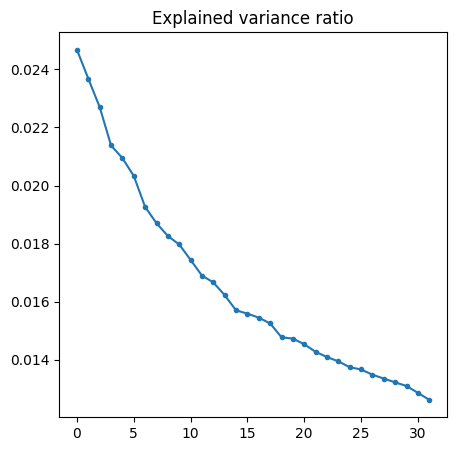

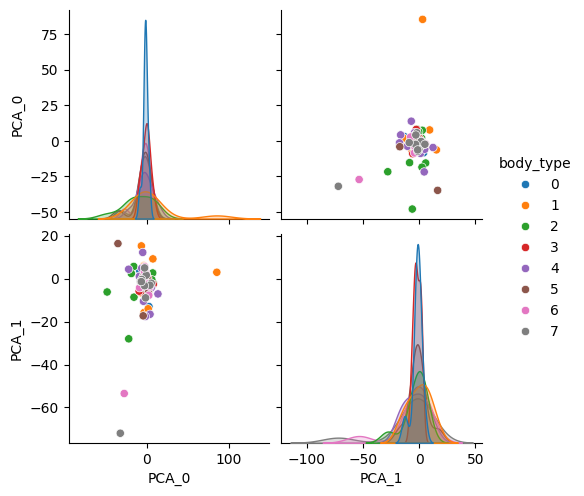

In [36]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

C_xy_orig_list_scaled = scaler.fit_transform(C_xy_orig_list.reshape(C_xy_orig_list.shape[0], -1))
C_xy_orig_list_pca = pca.fit_transform(C_xy_orig_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(C_xy_orig_list_pca[:, :2], columns=[f'PCA_{i}' for i in range(2)])

# remove the outliers based on standard deviation
# pca_df = pca_df[(np.abs(pca_df) < 50).all(axis=1)]


# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(C_xy_orig_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]

pca_df = pca_df[(np.abs(pca_df) < np.std(pca_df) * 6
                 ).all(axis=1)]

# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on original')
plt.show()



In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

prod_with_support_list_scaled = scaler.fit_transform(prod_with_support_list.reshape(prod_with_support_list.shape[0], -1))
prod_with_support_list_pca = pca.fit_transform(prod_with_support_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(prod_with_support_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(prod_with_support_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on product with support')
plt.show()



In [51]:
supp_vec_list.shape

torch.Size([80, 6890, 64])

In [ ]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

# supp_vec_list_scaled = scaler.fit_transform(supp_vec_list.reshape(supp_vec_list.shape[0], -1))
# supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)

supp_vec_list_scaled = scaler.fit_transform(
    (supp_vec_list.transpose(1, 2) @ supp_vec_list).reshape(supp_vec_list.shape[0], -1)
    )
supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(supp_vec_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(supp_vec_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on product with support')
plt.show()



In [ ]:
# supp_vec_list_product = supp_vec_list.transpose(1, 2) @ supp_vec_list
supp_vec_list_product = supp_vec_list_scaled.reshape(supp_vec_list.shape[0], feature_dim, feature_dim)

fig, axs = plt.subplots(1, 3, figsize=(15, 5))

axs_0 = axs[0].imshow(supp_vec_list_product[5], cmap='bwr')
plt.colorbar(axs_0, ax=axs[0])

axs_1 = axs[1].imshow(supp_vec_list_product[6], cmap='bwr')
plt.colorbar(axs_1, ax=axs[1])

axs_2 = axs[2].imshow(supp_vec_list_product[7], cmap='bwr')
plt.colorbar(axs_2, ax=axs[2])

plt.show()

PCA on product with support


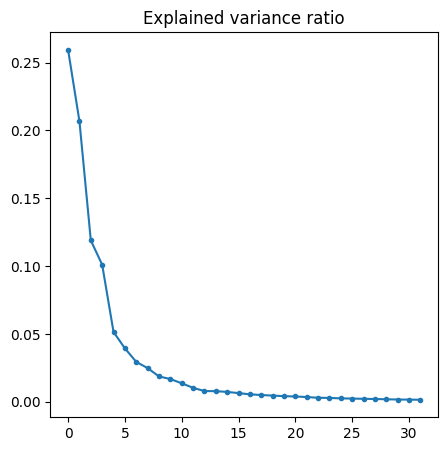

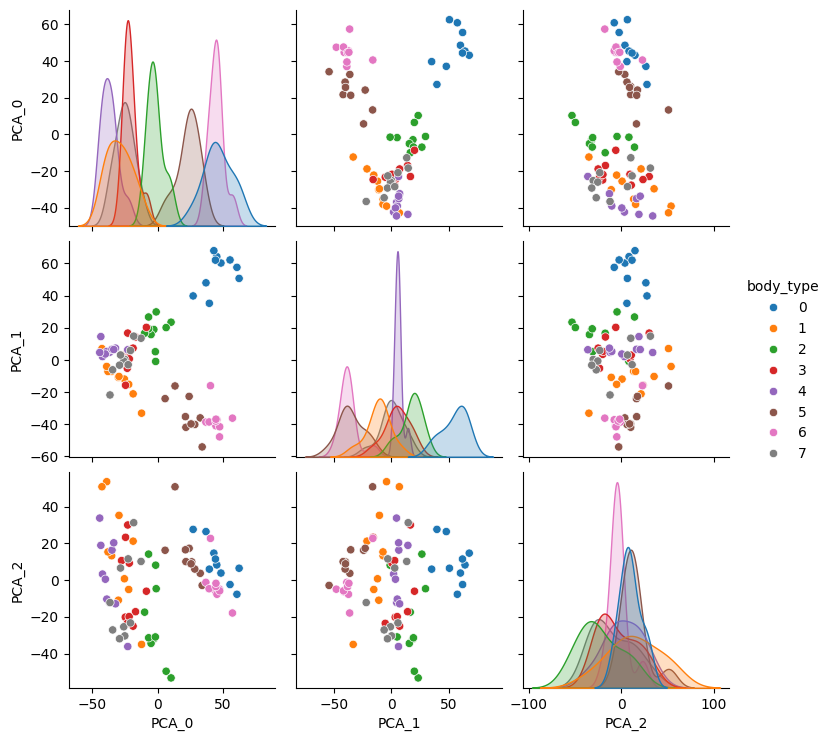

In [65]:
# apply standard scaling and PCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
import seaborn as sns
import pandas as pd


scaler = StandardScaler()
pca = PCA(n_components=32)

# supp_vec_list_scaled = scaler.fit_transform(supp_vec_list.reshape(supp_vec_list.shape[0], -1))
# supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)

supp_vec_list_scaled = scaler.fit_transform(
    (supp_vec_list.transpose(1, 2) @ supp_vec_list).reshape(supp_vec_list.shape[0], -1)
    )
supp_vec_list_pca = pca.fit_transform(supp_vec_list_scaled)


fig, axs = plt.subplots(1, 1, figsize=(5, 5))

# plot explained variance
axs.plot(pca.explained_variance_ratio_, '.-')
axs.set_title('Explained variance ratio')


pca_df = pd.DataFrame(supp_vec_list_pca[:, :3], columns=[f'PCA_{i}' for i in range(3)])
# pca_df['name'] = names_y
pca_df['body_type'] = [i // 10 for i in range(supp_vec_list_pca.shape[0])]
# pca_df['pose'] = [i % 10 for i in range(C_xy_orig_list_pca.shape[0])]


# use numbers as markers
sns.pairplot(pca_df, diag_kind='kde', hue='body_type', palette='tab10')

print('PCA on product with support')
plt.show()

